## 玩转BLS签名

### BLS12-381
BLS12-381是 pairing-friendly 的椭圆曲线。基于双线性对（pairing）的密码学已经发展了很多年，被用于简短数字签名(short digital signature)、基于身份的密码学（identity-based cryptography）、单轮多方密钥交换等领域。

pairing-friendly 的椭圆曲线是指有很好的嵌入度（favourable embedding degree）、很大的质数阶子群（large prime-order subgroup）。这种椭圆曲线很少，BLS曲线就是特地构造的符合条件的曲线。BLS12-381是Sean Bowe在2017年设计的椭圆曲线，用于对Zcash协议进行更新，该曲线pairing-friendly并且可用于高效构建zkSnarks。BLS12-381属于BLS曲线家族，由Barreto, Lynn, and Scott发明。

12：曲线的嵌入度

381：曲线上的点坐标表示所需的bit位数，即有限域的modulus q 的位数。因为点的坐标来自质数阶有限域，我们可以用384位（48Bytes）来表示每个域元素，留3 bit来做标志位或者算术优化。这个位数是由安全需求与实现高效所共同决定的。

### BLS12-381的最基本的椭圆曲线公式

$$ y^2=x^3+4 $$

曲线的参数由一个参数和几个方程来决定，该参数需要满足以下条件：

1. 具有low hamming weight，很少有位被置为1。This is particularly important for the efficiency of the algorithm that calculates pairings (the Miller loop).

2. 有限域的modulus q是质数，位数<=383位。which makes 64-bit or 32-bit arithmetic on it more efficient.

3. 子群的阶 r 是质数，且位数<=255位。which makes 64-bit or 32-bit arithmetic on it more efficient.

4. 安全等级是128位。

5. 为支持zkSnark需要一些限制 <br>
最终选定的参数= -0xd201000000010000 ，从这个参数可以计算出BLS12-381的其他参数：

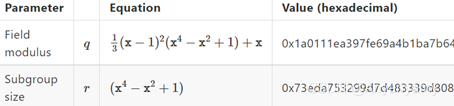

本文参考一个bls12-381的python实现，其代码链接为：https://github.com/pablo-vs/BLS

In [5]:
from curve import (
    curve_order,
    G1,
    G2,
    pairing,
)
from curve.encoding import (
    encodePubKey,
    decodePubKey,
    encodePrivKey,
    decodePrivKey,
    encodeSignature,
    decodeSignature,
    ENDIANNESS
)
import random
from hashlib import sha256
print(hex(curve_order), G1, G2)

0x73eda753299d7d483339d80809a1d80553bda402fffe5bfeffffffff00000001 BLS12_381_FQ(x=3685416753713387016781088315183077757961620795782546409894578378688607592378376318836054947676345821548104185464507, y=1339506544944476473020471379941921221584933875938349620426543736416511423956333506472724655353366534992391756441569) BLS12_381_FQ2(x=3059144344244213709971259814753781636986470325476647558659373206291635324768958432433509563104347017837885763365758u + 352701069587466618187139116011060144890029952792775240219908644239793785735715026873347600343865175952761926303160, y=927553665492332455747201965776037880757740193453592970025027978793976877002675564980949289727957565575433344219582u + 1985150602287291935568054521177171638300868978215655730859378665066344726373823718423869104263333984641494340347905)


In [10]:
# Represents a message as a point which belongs to the eliptic curve
# Simplified version (probably insecure)
def hashToPoint(message):
    # TODO secure hashing function
    hint = int.from_bytes(sha256(message).digest(), byteorder=ENDIANNESS)
    h = hint % curve_order
    return G2 * h


# Generates both public and secret keys
def keyGen():
    sk = random.randint(0, curve_order)
    pk = G1 * sk
    return pk, sk


# Generates a signature of a file
def sign(message, privKey):
    H = hashToPoint(message)
    signature = privKey * H
    return signature


# Checks the signature of a file
def verify(msg, sig, pubKey):
    H = hashToPoint(msg)
    p1 = pairing(pubKey, H)
    p2 = pairing(G1, sig)
    return p1 == p2

pk, sk = keyGen()
m = "helloworld"
s = sign(m.encode(), sk)
h = hashToPoint(m.encode())
print(h)
print(pairing(pk, h))
print(pairing(G1, s))
print(s)
print(verify(m.encode(), s, pk))

BLS12_381_FQ2(x=977733473114161872075370852018673601162879399908757936061553108190862035154578973243927770318547204908640552834252u + 3154072577967332945045628105273493077042815221339518442505588760014195919277274985740661576655590605836353350968913, y=3478592704673945293824973229664709691213858351609241882830614326261914963609674587275046193283050374711500527385477u + 3237918459895937250208598198566015237893660533904503791403353671023669281421118489743348040529751742062266174565049)
2851489219170192886523410861817918694888553879300418027673616231845841541659576023168751403738354641706653521145478u¹¹ + 378821701048779398452152629960443277749037159292135102433143289118060001390733328601523697170245194761868860343247u¹⁰ + 2837023216649742967494516098460860637836591670250231890674245955245513628643628809969732285223528910206223839566644u⁹ + 1259245509635743681318058714397324111336559463515882505794586229335388589150866381328164621875160879817833622490226u⁸ + 176478218034139657549642363079

上面代码的运行结果来对照解释BLS签名算法原理。BLS的签名算法涉及到三个群$G_1, G_2, G_T$，分别为BLS12_381_FQ, BLS12_381_FQ2, BLS12_381_FQ12。签名结果是$G_2$群的一个点，验签算法pairing的两个参数分别是$(G_1, G_2)$上的一个点，输出结果是$G_T$上一个多项式，$G_T$是一个$F_{Q^{12}}$的GF域，$G_2$是$G_1$的扩域，可以类比复数域对实数域的扩展，通过引入一个u（在复数里是就是著名的$i=\sqrt{-1}$)来让其继续满足原来$G_1$域上的模q的加减乘除四则运算。